# LR multi-tissue cross-comparison

##### Ver:: A1_V5
##### Author(s) : Issac Goh
##### Date : 220823;YYMMDD
### Author notes
    - Current defaults scrpae data from web, so leave as default and run
    - slices model and anndata to same feature shape, scales anndata object
    - added some simple benchmarking
    - creates dynamic cutoffs for probability score (x*sd of mean) in place of more memory intensive confidence scoring
    - Does not have majority voting set on as default, but module does exist
    - Multinomial logistic relies on the (not always realistic) assumption of independence of irrelevant alternatives whereas a series of binary logistic predictions does not. collinearity is assumed to be relatively low, as it becomes difficult to differentiate between the impact of several variables if this is not the case
    
### Features to add
    - Add ability to consume anndata zar format for sequential learning
### Modes to run in
    - Run in training mode
    - Run in projection mode

In [1]:
import sys
import subprocess

# import pkg_resources
# required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
# installed = {pkg.key for pkg in pkg_resources.working_set}
# missing = required - installed
# if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
#from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
from pathlib import Path
import requests
import psutil
import random
import threading
import tracemalloc
import itertools
import math
import warnings

In [2]:
models = {
'pan_fetal':'/nfs/team205/ig7/resources/scripts_dont_modify/logit_regression_models/adifa_lr/celltypist_model.Pan_Fetal_Human.pkl',
'pan_fetal_wget':'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl',
'adata_scvi':'/nfs/team205/ig7/mount/gdrive/g_cloud/projects/amniontic_fluid/scvi_low_dim_model.sav',
'adata_ldvae':'/nfs/team205/ig7/mount/gdrive/g_cloud/projects/amniontic_fluid/ldvae_low_dim_model.sav',
'adata_harmony':'/nfs/team205/ig7/work_backups/backup_210306/projects/amiotic_fluid/train_low_dim_model/organ_low_dim_model.sav',
'test_low_dim_ipsc_ys':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Integrating_HM_data_030522/YS_logit/lr_model.sav',
'YS_X':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/YS_X_model_080922.sav',
'YS_X_V3':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/train_YS_full_X_model/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav'

}

adatas_dict = {
'Fetal_skin_raw': '/nfs/team298/hg6/Fetal_skin/data/FS_raw_sub.h5ad',
'vascular_organoid': '/nfs/team298/hg6/Fetal_skin/data/vasc_org_raw.h5ad',
'YS':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V5_scvi_YS_integrated/A2_V5_scvi_YS_integrated_raw_qc_scr_umap.h5ad',
'YS_test':'/nfs/team205/ig7/resources/scripts_dont_modify/logit_regression_models/LR_app_format/ys_test_data.h5ad',
}

# Variable assignment
train_model = False
feat_use = 'joint_annotation_20220202'
adata_key = 'Fetal_skin_raw'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)
model_key = 'YS_X_V3'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local 
train_x_partition = 'X' # what partition was the data trained on? To keep simple, for now only accepts 'X'
dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = 'joint_annotation_20220202'#'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
penalty='elasticnet' # can be ["l1","l2","elasticnet"]
sparcity=0.2
thread_num = -1

partial_scale = False
QC_normalise = True

# Partial scaling ver
- scale across 10 mini bulks/every 100,000 cells
- sequential learning for scaling
- sequential application of scaling

In [8]:
def load_models(model_dict,model_run):
    if (Path(model_dict[model_run])).is_file():
        # Load data (deserialize)
        model = pkl.load(open(model_dict[model_run], "rb"))
        return model
    elif 'https' in model_dict[model_run]:
        print('Loading model from web source')
        r_get = requests.get(model_dict[model_run])
        fpath = './model_temp.sav'
        open(fpath , 'wb').write(r_get.content)
        model = pkl.load(open(fpath, "rb"))
        return model

def load_adatas(adatas_dict,data_merge, data_key_use,QC_normalise):
    if data_merge == True:
        # Read
        gene_intersect = {} # unused here
        adatas = {}
        for dataset in adatas_dict.keys():
            if 'https' in adatas_dict[dataset]:
                print('Loading anndata from web source')
                adatas[dataset] = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[dataset])
            adatas[dataset] = sc.read(data[dataset])
            adatas[dataset].var_names_make_unique()
            adatas[dataset].obs['dataset_merge'] = dataset
            adatas[dataset].obs['dataset_merge'] = dataset
            gene_intersect[dataset] = list(adatas[dataset].var.index)
        adata = list(adatas.values())[0].concatenate(list(adatas.values())[1:],join='inner')
        return adatas, adata
    elif data_merge == False:
        if 'https' in adatas_dict[data_key_use]:
            print('Loading anndata from web source')
            adata = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[data_key_use])
        else: 
            adata = sc.read(adatas_dict[data_key_use])
    if QC_normalise == True:
        sc.pp.filter_cells(adata, min_genes=200)
        sc.pp.filter_genes(adata, min_cells=3)
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
        sc.pp.log1p(adata)
        
        del adata.uns
        del adata.obsp
        return adata

# resource usage logger
class DisplayCPU(threading.Thread):
    def run(self):
        tracemalloc.start()
        starting, starting_peak = tracemalloc.get_traced_memory()
        self.running = True
        self.starting = starting
        currentProcess = psutil.Process()
        cpu_pct = []
        while self.running:
            peak_cpu = 0
#           time.sleep(3)
#             print('CPU % usage = '+''+ str(currentProcess.cpu_percent(interval=1)))
#             cpu_pct.append(str(currentProcess.cpu_percent(interval=1)))
            cpu = currentProcess.cpu_percent()
        # track the peak utilization of the process
            if cpu > peak_cpu:
                peak_cpu = cpu
                peak_cpu_per_core = peak_cpu/psutil.cpu_count()
        self.peak_cpu = peak_cpu
        self.peak_cpu_per_core = peak_cpu_per_core
        
    def stop(self):
#        cpu_pct = DisplayCPU.run(self)
        self.running = False
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        return current, peak
    
# projection module
def reference_projection(adata, model, dyn_std,partial_scale,):
    
    class adata_temp:
        pass
    from sklearn.preprocessing import StandardScaler
    print('Determining model flavour')
    try:
        model_lr =  model['Model']
        print('Consuming celltypist model')
    except:# hasattr(model, 'coef_'):
        print('Consuming non-celltypist model')
        model_lr =  model
    print(model_lr)
    
#     model_lr =  model['Model']
    if partial_scale == True:
        if train_x_partition == 'X':
            print('Matching reference genes in the model')
            k_x = np.isin(list(adata.var.index), list(model_lr.features))
            if k_x.sum() == 0:
                raise ValueError(f"🛑 No features overlap with the model. Please provide gene symbols")
            print(f"🧬 {k_x.sum()} features used for prediction")
            #slicing adata
            k_x_idx = np.where(k_x)[0]
            # adata_temp = adata[:,k_x_idx]
            adata_temp.var = adata[:,k_x_idx].var
            adata_temp.X = adata[:,k_x_idx].X
            adata_temp.obs = adata[:,k_x_idx].obs
            lr_idx = pd.DataFrame(model_lr.features, columns=['features']).reset_index().set_index('features').loc[list(adata_temp.var.index)].values
            # adata_arr = adata_temp.X[:,list(lr_idexes['index'])]

            # slice and reorder model
            ni, fs, cf = model_lr.n_features_in_, model_lr.features, model_lr.coef_
            model_lr.n_features_in_ = lr_idx.size
            model_lr.features = np.array(model_lr.features)[lr_idx]
            model_lr.coef_ = np.squeeze(model_lr.coef_[:,lr_idx]) #model_lr.coef_[:, lr_idx]

            print('scaling input data, default option is to use incremental learning and fit in mini bulks!')
            # Partial scaling alg
            scaler = StandardScaler(with_mean=False)
            n = adata_temp.X.shape[0]  # number of rows
            # set dyn scale packet size
            x_len = len(adata_temp.var)
            y_len = len(adata.obs)
            if y_len < 100000:
                dyn_pack = int(x_len/10)
                pack_size = dyn_pack
            else:
                # 10 pack for every 100,000
                dyn_pack = int((y_len/100000)*10)
                pack_size = int(x_len/dyn_pack)

            batch_size =  1000#pack_size#500  # number of rows in each call to partial_fit
            index = 0  # helper-var
            while index < n:
                partial_size = min(batch_size, n - index)  # needed because last loop is possibly incomplete
                partial_x = adata_temp.X[index:index+partial_size]
                scaler.partial_fit(partial_x)
                index += partial_size
            adata_temp.X = scaler.transform(adata_temp.X)
        else:
            adata_temp = adata.copy()
    
    # model projections
    print('Starting reference projection!')
    if train_x_partition == 'X':
        train_x = adata_temp.X
        pred_out = pd.DataFrame(model_lr.predict(train_x),columns = ['predicted'],index = list(adata.obs.index))
        proba =  pd.DataFrame(model_lr.predict_proba(train_x),columns = model_lr.classes_,index = list(adata.obs.index))
        pred_out = pred_out.join(proba)
        
    elif train_x_partition in list(adata.obsm.keys()): 
        print('{low_dim: this partition modality is still under development!}')
        train_x = adata.obsm[train_x_partition]
        pred_out = pd.DataFrame(model_lr.predict(train_x),columns = ['predicted'],index = list(adata.obs.index))
        proba =  pd.DataFrame(model_lr.predict_proba(train_x),columns = model_lr.classes_,index = list(adata.obs.index))
        pred_out = pred_out.join(proba)
    
    else:
        print('{this partition modality is still under development!}')
    ## insert modules for low dim below

    # Simple dynamic confidence calling
    pred_out['confident_calls'] = pred_out['predicted']
    pred_out.loc[pred_out.max(axis=1)<(pred_out.mean(axis=1) + (1*pred_out.std(axis=1))),'confident_calls'] = pred_out.loc[pred_out.max(axis=1)<(pred_out.mean(axis=1) + (1*pred_out.std(axis=1))),'confident_calls'].astype(str) + '_uncertain'
    # means_ = self.model.scaler.mean_[lr_idx] if self.model.scaler.with_mean else 0
    return(pred_out,train_x,model_lr,adata_temp)

def freq_redist_68CI(adata,clusters_reassign):
    if freq_redist != False:
        print('Frequency redistribution commencing')
        cluster_prediction = "consensus_clus_prediction"
        lr_predicted_col = 'predicted'
        pred_out[clusters_reassign] = adata.obs[clusters_reassign].astype(str)
        reassign_classes = list(pred_out[clusters_reassign].unique())
        lm = 1 # lambda value
        pred_out[cluster_prediction] = pred_out[clusters_reassign]
        for z in pred_out[clusters_reassign][pred_out[clusters_reassign].isin(reassign_classes)].unique():
            df = pred_out
            df = df[(df[clusters_reassign].isin([z]))]
            df_count = pd.DataFrame(df[lr_predicted_col].value_counts())
            # Look for classificationds > 68CI
            if len(df_count) > 1:
                df_count_temp = df_count[df_count[lr_predicted_col]>int(int(df_count.mean()) + (df_count.std()*lm))]
                if len(df_count_temp >= 1):
                    df_count = df_count_temp
            #print(df_count)     
            freq_arranged = df_count.index
            cat = freq_arranged[0]
        #Make the cluster assignment first
            pred_out[cluster_prediction] = pred_out[cluster_prediction].astype(str)
            pred_out.loc[pred_out[clusters_reassign] == z, [cluster_prediction]] = cat
        # Create assignments for any classification >68CI
            for cats in freq_arranged:
                #print(cats)
                cats_assignment = cats#.replace(data1,'') + '_clus_prediction'
                pred_out.loc[(pred_out[clusters_reassign] == z) & (pred_out[lr_predicted_col] == cats),[cluster_prediction]] = cats_assignment
        min_counts = pd.DataFrame((pred_out[cluster_prediction].value_counts()))
        reassign = list(min_counts.index[min_counts[cluster_prediction]<=2])
        pred_out[cluster_prediction] = pred_out[cluster_prediction].str.replace(str(''.join(reassign)),str(''.join(pred_out.loc[pred_out[clusters_reassign].isin(list(pred_out.loc[(pred_out[cluster_prediction].isin(reassign)),clusters_reassign])),lr_predicted_col].value_counts().head(1).index.values)))
        return pred_out

### Feature importance notes
#- If we increase the x feature one unit, then the prediction will change e to the power of its weight. We can apply this rule to the all weights to find the feature importance.
#- We will calculate the Euler number to the power of its coefficient to find the importance.
#- To sum up an increase of x feature by one unit increases the odds of being versicolor class by a factor of x[importance] when all other features remain the same.

#- For low-dim, we look at the distribution of e^coef per class, we extract the 


# class coef_extract:
#     def __init__(self, model,features, pos):
# #         self.w = list(itertools.chain(*(model.coef_[pos]).tolist())) #model.coef_[pos]
#         self.w = model.coef_[class_pred_pos]
#         self.features = features 

def long_format_features(top_loadings):
    p = top_loadings.loc[:, top_loadings.columns.str.endswith("_e^coef")]
    p = pd.melt(p)
    n = top_loadings.loc[:, top_loadings.columns.str.endswith("_feature")]
    n = pd.melt(n)
    l = top_loadings.loc[:, top_loadings.columns.str.endswith("_coef")]
    l = pd.melt(l)
    n = n.replace(regex=r'_feature', value='')
    n = n.rename(columns={"variable": "class", "value": "feature"})
    p = (p.drop(["variable"],axis = 1)).rename(columns={ "value": "e^coef"})
    l = (l.drop(["variable"],axis = 1)).rename(columns={ "value": "coef"})
    concat = pd.concat([n,p,l],axis=1)
    return concat

def model_feature_sf(long_format_feature_importance, coef_use):
        long_format_feature_importance[str(coef_use) + '_pval'] = 'NaN'
        for class_lw in long_format_feature_importance['class'].unique():
            df_loadings = long_format_feature_importance[long_format_feature_importance['class'].isin([class_lw])]
            comps = coef_use #'e^coef'
            U = np.mean(df_loadings[comps])
            std = np.std(df_loadings[comps])
            med =  np.median(df_loadings[comps])
            mad = np.median(np.absolute(df_loadings[comps] - np.median(df_loadings[comps])))
            # Survival function scaled by 1.4826 of MAD (approx norm)
            pvals = scipy.stats.norm.sf(df_loadings[comps], loc=med, scale=1.4826*mad) # 95% CI of MAD <10,000 samples
            #pvals = scipy.stats.norm.sf(df_loadings[comps], loc=U, scale=1*std)
            df_loadings[str(comps) +'_pval'] = pvals
            long_format_feature_importance.loc[long_format_feature_importance.index.isin(df_loadings.index)] = df_loadings
        long_format_feature_importance['is_significant_sf'] = False
        long_format_feature_importance.loc[long_format_feature_importance[coef_use+ '_pval']<0.05,'is_significant_sf'] = True
        return long_format_feature_importance
# Apply SF to e^coeff mat data
#         pval_mat = pd.DataFrame(columns = mat.columns)
#         for class_lw in mat.index:
#             df_loadings = mat.loc[class_lw]
#             U = np.mean(df_loadings)
#             std = np.std(df_loadings)
#             med =  np.median(df_loadings)
#             mad = np.median(np.absolute(df_loadings - np.median(df_loadings)))
#             pvals = scipy.stats.norm.sf(df_loadings, loc=med, scale=1.96*U)

class estimate_important_features: # This calculates feature effect sizes of the model
    def __init__(self, model, top_n):
        print('Estimating feature importance')
        classes =  list(model.classes_)
         # get feature names
        try:
            model_features = list(itertools.chain(*list(model.features)))
        except:
            warnings.warn('no features recorded in data, naming features by position')
            print('if low-dim lr was submitted, run linear decoding function to obtain true feature set')
            model_features = list(range(0,model.coef_.shape[1]))
            model.features = model_features
        print('Calculating the Euler number to the power of coefficients')
        impt_ = pow(math.e,model.coef_)
        try:
            self.euler_pow_mat = pd.DataFrame(impt_,columns = list(itertools.chain(*list(model.features))),index = list(model.classes_))
        except:
            self.euler_pow_mat = pd.DataFrame(impt_,columns = list(model.features),index = list(model.classes_))
        self.top_n_features = pd.DataFrame(index = list(range(0,top_n)))
        # estimate per class feature importance
        
        print('Estimating feature importance for each class')
        mat = self.euler_pow_mat
        for class_pred_pos in list(range(0,len(mat.T.columns))):
            class_pred = list(mat.T.columns)[class_pred_pos]
            #     print(class_pred)
            temp_mat =  pd.DataFrame(mat.T[class_pred])
            temp_mat['coef'] = model.coef_[class_pred_pos]
            temp_mat = temp_mat.sort_values(by = [class_pred], ascending=False)
            temp_mat = temp_mat.reset_index()
            temp_mat.columns = ['feature','e^coef','coef']
            temp_mat = temp_mat[['feature','e^coef','coef']]
            temp_mat.columns =str(class_pred)+ "_" + temp_mat.columns
            self.top_n_features = pd.concat([self.top_n_features,temp_mat.head(top_n)], join="inner",ignore_index = False, axis=1)
            self.to_n_features_long = model_feature_sf(long_format_features(self.top_n_features),'e^coef')
            
    
    # plot class-wise features
def model_class_feature_plots(top_loadings, classes, comps):
    import matplotlib.pyplot as plt
    %matplotlib inline  
    for class_temp in classes:
        class_lw = class_temp
        long_format = top_loadings
        df_loadings = long_format[long_format['class'].isin([class_lw])]
        plt.hist(df_loadings[comps])
        for i in ((df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]).unique()):
            plt.axvline(x=i,color='red')
        med = np.median(df_loadings[comps])
        plt.axvline(x=med,color='blue')
        plt.xlabel('feature_importance', fontsize=12)
        plt.title(class_lw)
        #plt.axvline(x=med,color='pink')
        df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]
        print(len(df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]))
        #Plot feature ranking
        plot_loading = pd.DataFrame(pd.DataFrame(df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]).iloc[:,0].sort_values(ascending=False))
        table = plt.table(cellText=plot_loading.values,colWidths = [1]*len(plot_loading.columns),
        rowLabels= list(df_loadings['feature'][df_loadings.index.isin(plot_loading.index)].reindex(plot_loading.index)), #plot_loading.index,
        colLabels=plot_loading.columns,
        cellLoc = 'center', rowLoc = 'center',
        loc='right', bbox=[1.4, -0.05, 0.5,1])
        table.scale(1, 2)
        table.set_fontsize(16)
        
def report_f1(model,train_x, train_label):
    ## Report accuracy score
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn import metrics
    import seaborn as sn
    import pandas as pd
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    
    # cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)
    # # evaluate the model and collect the scores
    # n_scores = cross_val_score(lr, train_x, train_label, scoring='accuracy', cv=cv, n_jobs=-1)
    # # report the model performance
    # print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

    # Report Precision score
    metric = pd.DataFrame((metrics.classification_report(train_label, model.predict(train_x), digits=2,output_dict=True))).T
    cm = confusion_matrix(train_label, model.predict(train_x))
    #cm = confusion_matrix(train_label, model.predict_proba(train_x))
    df_cm = pd.DataFrame(cm, index = lr.classes_,columns = lr.classes_)
    df_cm = (df_cm / df_cm.sum(axis=0))*100
    plt.figure(figsize = (20,15))
    sn.set(font_scale=1) # for label size
    pal = sns.diverging_palette(240, 10, n=10)
    #plt.suptitle(('Mean Accuracy 5 fold: %.3f std: %.3f' % (np.mean(n_scores),  np.std(n_scores))), y=1.05, fontsize=18)
    #Plot precision recall and recall
    table = plt.table(cellText=metric.values,colWidths = [1]*len(metric.columns),
    rowLabels=metric.index,
    colLabels=metric.columns,
    cellLoc = 'center', rowLoc = 'center',
    loc='bottom', bbox=[0.25, -0.6, 0.5, 0.3])
    table.scale(1, 2)
    table.set_fontsize(16)

    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=pal) # font size
    print(metrics.classification_report(train_label, model.predict(train_x), digits=2))

def subset_top_hvgs(adata_lognorm, n_top_genes):
    dispersion_norm = adata_lognorm.var['dispersions_norm'].values.astype('float32')

    dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
    dispersion_norm[
                ::-1
            ].sort()  # interestingly, np.argpartition is slightly slower

    disp_cut_off = dispersion_norm[n_top_genes - 1]
    gene_subset = adata_lognorm.var['dispersions_norm'].values >= disp_cut_off
    return(adata_lognorm[:,gene_subset])

def prep_scVI(adata, 
              n_hvgs = 5000,
              remove_cc_genes = True,
              remove_tcr_bcr_genes = False
             ):
    ## Remove cell cycle genes
    if remove_cc_genes:
        adata = panfetal_utils.remove_geneset(adata,genes.cc_genes)

    ## Remove TCR/BCR genes
    if remove_tcr_bcr_genes:
        adata = panfetal_utils.remove_geneset(adata, genes.IG_genes)
        adata = panfetal_utils.remove_geneset(adata, genes.TCR_genes)
        
    ## HVG selection
    adata = subset_top_hvgs(adata, n_top_genes=n_hvgs)
    return(adata)

def LR_train(adata, train_x, train_label, penalty=penalty, sparcity=sparcity,max_iter=200,l1_ratio =0.2):
    lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter, n_jobs=thread_num)
    if (penalty == "l1"):
        lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter, dual = True, solver = 'liblinear',multi_class = 'ovr', n_jobs=thread_num ) # one-vs-rest
    if (penalty == "elasticnet"):
        lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter, dual=False,solver = 'saga',l1_ratio=l1_ratio,multi_class = 'ovr', n_jobs=thread_num)
    if train_x == 'X':
        subset_train = adata.obs.index
        # Define training parameters
        train_label = adata.obs[train_label].values
#        predict_label = train_label[subset_predict]
#        train_label = train_label[subset_train]
        train_x = adata.X#[adata.obs.index.isin(list(adata.obs[subset_train].index))]
#        predict_x = adata.X[adata.obs.index.isin(list(adata.obs[subset_predict].index))]
    elif train_x in adata.obsm.keys():
        # Define training parameters
        train_label = adata.obs[train_label].values
#        predict_label = train_label[subset_predict]
#         train_label = train_label[subset_train]
        train_x = adata.obsm[train_x]
#        predict_x = train_x
#        train_x = train_x[subset_train, :]
        # Define prediction parameters
#        predict_x = predict_x[subset_predict]
#        predict_x = pd.DataFrame(predict_x)
#        predict_x.index = adata.obs[subset_predict].index
    # Train predictive model using user defined partition labels (train_x ,train_label, predict_x)
    model = lr.fit(train_x, train_label)
    model.features = np.array(adata.var.index)
    return model

def prep_training_data(adata_temp,feat_use,batch_key, model_name = (model_key + '_lr_model'),var_length = 7500,penalty='elasticnet',sparcity=0.2,max_iter = 200,l1_ratio = 0.1,partial_scale=True,train_x_partition ='X'):
    # basic filtering
#    sc.pp.filter_cells(adata_temp, min_genes=200)
#    sc.pp.filter_genes(adata_temp, min_cells=3)
    #standardise
#    sc.pp.normalize_per_cell(adata_temp, counts_per_cell_after=1e4)
    adata_temp.X = (adata_temp.X.astype(int))
    sc.pp.log1p(adata_temp)
    sc.pp.highly_variable_genes(adata_temp, batch_key = batch_key, subset=False)
    adata_temp = subset_top_hvgs(adata_temp,var_length)
    #scale the input data
    if partial_scale == True:
        print('scaling input data, default option is to use incremental learning and fit in mini bulks!')
        # Partial scaling alg
        scaler = StandardScaler(with_mean=False)
        n = adata_temp.X.shape[0]  # number of rows
        # set dyn scale packet size
        x_len = len(adata_temp.var)
        y_len = len(adata.obs)
        if y_len < 100000:
            dyn_pack = int(x_len/10)
            pack_size = dyn_pack
        else:
            # 10 pack for every 100,000
            dyn_pack = int((y_len/100000)*10)
            pack_size = int(x_len/dyn_pack)
        batch_size =  1000#pack_size#500  # number of rows in each call to partial_fit
        index = 0  # helper-var
        while index < n:
            partial_size = min(batch_size, n - index)  # needed because last loop is possibly incomplete
            partial_x = adata_temp.X[index:index+partial_size]
            scaler.partial_fit(partial_x)
            index += partial_size
        adata_temp.X = scaler.transform(adata_temp.X)
#     else:
#         sc.pp.scale(adata_temp, zero_center=True, max_value=None, copy=False, layer=None, obsm=None)
        
    # train model
#    train_x = adata_temp.X
    #train_label = adata_temp.obs[feat_use]
    model = LR_train(adata_temp, train_x = train_x_partition, train_label=feat_use, penalty=penalty, sparcity=sparcity,max_iter=max_iter,l1_ratio = l1_ratio)
    model.features = list(adata_temp.var.index)
    return model

In [9]:
if train_model == True:
    from sklearn.preprocessing import StandardScaler
    adata =  load_adatas(adatas_dict, data_merge, adata_key)
    print('adata_loaded')
    model_trained = prep_training_data(feat_use = feat_use,
    adata_temp = adata,
    train_x_partition = train_x_partition,
    model_name = model_key + '_lr_model',
    var_length = 7500,
    batch_key = 'donor',
    penalty='elasticnet', # can be ["l1","l2","elasticnet"],
    sparcity=0.2, #If using LR without optimisation, this controls the sparsity in model
    max_iter = 1000, #Increase if experiencing max iter issues
    l1_ratio = 0.2, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
    partial_scale = False
    )
    filename =model_name
    pkl.dump(model_trained, open(filename, 'wb'))

# Read in query data for projection

In [ ]:
if train_model == True:
    from sklearn.preprocessing import StandardScaler
    adata =  load_adatas(adatas_dict, data_merge, adata_key,QC_normalise)
    print('adata_loaded')
    model_trained = prep_training_data(feat_use = feat_use,
    adata_temp = adata,
    train_x_partition = train_x_partition,
    model_name = model_key + '_lr_model',
    var_length = 7500,
    batch_key = 'donor',
    penalty='elasticnet', # can be ["l1","l2","elasticnet"],
    sparcity=0.2, #If using LR without optimisation, this controls the sparsity in model
    max_iter = 1000, #Increase if experiencing max iter issues
    l1_ratio = 0.2, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
    partial_scale = False
    )
    filename =model_name
    pkl.dump(model_trained, open(filename, 'wb'))
    
    model_lr= model_trained
    adata =  load_adatas(adatas_dict, data_merge, adata_key)
else:
    adata =  load_adatas(adatas_dict, data_merge, adata_key,QC_normalise)
    model = load_models(models,model_key)
    model_lr=  model
# run with usage logger
import time
t0 = time.time()
display_cpu = DisplayCPU()
display_cpu.start()
try: #code here ##
    pred_out,train_x,model_lr,adata_temp = reference_projection(adata, model_lr, dyn_std,partial_scale)
    if freq_redist != False:
        pred_out = freq_redist_68CI(adata,freq_redist)
        pred_out['orig_labels'] = adata.obs[freq_redist]
        adata.obs['consensus_clus_prediction'] = pred_out['consensus_clus_prediction']
    adata.obs['predicted'] = pred_out['predicted']
    adata_temp.obs = adata.obs
    
    # Estimate top model features for class descrimination
    feature_importance = estimate_important_features(model_lr, 100)
    mat = feature_importance.euler_pow_mat
    top_loadings = feature_importance.to_n_features_long
    
    # Estimate dataset specific feature impact
#     for classes in ['pDC precursor_ys_HL','AEC_ys_HL']:
#         model_class_feature_plots(top_loadings, [str(classes)], 'e^coef')
#         plt.show()
finally: #
    current, peak = display_cpu.stop()
t1 = time.time()
time_s = t1-t0
print('projection complete!')
time.sleep(3)
print('projection time was ' + str(time_s) + ' seconds')
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
print(f"starting memory usage is" +'' + str(display_cpu.starting))
print('peak CPU % usage = '+''+ str(display_cpu.peak_cpu))
print('peak CPU % usage/core = '+''+ str(display_cpu.peak_cpu_per_core))

In [ ]:
model_mean_probs = pred_out.loc[:, pred_out.columns != 'predicted'].groupby('orig_labels').median()
model_mean_probs = model_mean_probs*100
model_mean_probs = model_mean_probs.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
crs_tbl = model_mean_probs.copy()
# Sort df columns by rows
index_order = list(crs_tbl.max(axis=1).sort_values(ascending=False).index)
col_order = list(crs_tbl.max(axis=0).sort_values(ascending=False).index)
crs_tbl = crs_tbl.loc[index_order]
crs_tbl = crs_tbl[col_order]
# Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.5)
g = sns.heatmap(crs_tbl, cmap=pal,  annot=True,vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})

plt.ylabel("Original labels")
plt.xlabel("Training labels")
#plt.savefig('./ldvae_ver5_lr_model_means_subclusters.pdf',dpi=300)
plt.show()

# Save predicted output

In [ ]:
pred_out.to_csv('./A1_V1_2_organoid_predictions.csv')

 # Significant contributors to feature effect size per class of model
     - Bear in mind these are only top features..
    - assess the positive descriminators (markers) of the model
    - “…provide information about the magnitude and direction of the difference between two groups or the relationship between two variables.”

In [ ]:
for classes in ['Endoderm_ys_HL','AEC_ys_HL','Sinusoidal_EC_ys_HL']:
    model_class_feature_plots(top_loadings, [str(classes)], 'e^coef')
    plt.show()

In [22]:
top_loadings

,class,feature,e^coef,coef,e^coef_pval,is_significant_sf
0,AEC_ys_HL,GJA4,1.409593,0.343301,0.0,True
1,AEC_ys_HL,HSPG2,1.273430,0.241714,0.0,True
2,AEC_ys_HL,GJA5,1.260795,0.231743,0.0,True
3,AEC_ys_HL,KDR,1.216654,0.196104,0.000058,True
4,AEC_ys_HL,LIFR,1.215126,0.194848,0.000073,True
...,...,...,...,...,...,...
3995,pDC precursor_ys_HL,PAG1,1.037108,0.036436,0.790654,False
3996,pDC precursor_ys_HL,DUSP4,1.037004,0.036336,0.791153,False
3997,pDC precursor_ys_HL,NCF4,1.036707,0.036049,0.792566,False
3998,pDC precursor_ys_HL,HERPUD1,1.035053,0.034453,0.800323,False


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


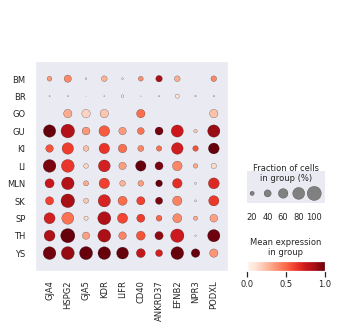

In [30]:
sc.pl.dotplot(adata[adata.obs['predicted'].isin(['AEC_ys_HL'])], groupby = 'organ', var_names = list(top_loadings.loc[top_loadings['class'].isin(['AEC_ys_HL']),'feature'].head(10)),standard_scale='var')

# Estimating dataset-specific Feature importance
 - let's also now consider the intersect between model and projected data

# Let's calculate an impact and specificty score for each cell

- We create a variable model impact factor by multiplying gene x model coeficient for class
- This is the variable contribution of each feature for a class prediction given a model and data

$X = $$\begin{bmatrix}(e^{coeff}_{n} * g1),(e^{coeff}_{n} * g2) \\ (e^{coeff}_{n} * g1),(e^{coeff}_{n} * g2) \\ (e^{coeff}_{n} * g1),(e^{coeff}_{n} * g2) \\ ..... \end{bmatrix}$

- We create a summed feature impact score for each cell by summing per feature ipact scores which identifies the overarching impact of a model's contribution.. == total model impact score

$Impact_{cellx} = $$\begin{bmatrix}(e^{coeff}_{n} * g1) + \ (e^{coeff}_{n} * g2) \ +(e^{coeff}_{n} * g3) \ + ..... \end{bmatrix}$

- We measure the model feature effect on class decisoion betwene organs and withi organs
- We can now use these feature availability/impact metrics to compare the availability and differential impact of features between data

In [32]:
from scipy import sparse

# temp
var = 'predicted'
adata_model = adata[:,list(adata_temp.var.index)]
adata_model.obs['model_topn_feature_impact'] = 0

#loop
long_format = top_loadings
for class_temp in model.classes_:
    adata_model[adata_model.obs[var].isin([class_temp])].X= sparse.csr_matrix((np.multiply((adata_model[adata_model.obs[var].isin([class_temp])].X.todense()),np.array(mat.loc[class_temp]))))
    # Impact of top n features
    adata_model.obs.loc[adata_model.obs[var].isin([class_temp]),'model_topn_feature_impact'] = np.log(np.sum(np.multiply(adata_model[adata_model.obs[var].isin([class_temp])][:,list(long_format[long_format['class'].isin([class_temp])].feature)].X.todense(), np.array(long_format[long_format['class'].isin([class_temp])]['e^coef'])),axis =1))
# Total impact of all model features
adata_model.obs['model_class_impact_total'] = np.log([item for sublist in (np.sum(adata_model.X,axis=1)).tolist() for item in sublist])
adata_model.obs[['model_topn_feature_impact','model_class_impact_total']]

<ipython-input-32-b91090693e07>:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_model.obs['model_topn_feature_impact'] = 0
<ipython-input-32-b91090693e07>:13: RuntimeWarning: divide by zero encountered in log
  adata_model.obs.loc[adata_model.obs[var].isin([class_temp]),'model_topn_feature_impact'] = np.log(np.sum(np.multiply(adata_model[adata_model.obs[var].isin([class_temp])][:,list(long_format[long_format['class'].isin([class_temp])].feature)].X.todense(), np.array(long_format[long_format['class'].isin([class_temp])]['e^coef'])),axis =1))
<ipython-input-32-b91090693e07>:15: RuntimeWarning: divide by zero encountered in log
  adata_model.obs['model_class_impact_total'] = np.log([item for sublist in (np.sum(adata_model.X,axis=1)).tolist() for item in sublist])
<ipython-input-32-b91090693e07>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

,model_topn_feature_impact,model_class_impact_total
FCAImmP7579224-ATTACTCTCGATGAGG,5.567179,6.897207
FCAImmP7579224-CAGCCGAGTACATCCA,5.333402,6.520750
FCAImmP7579224-TGCTACCTCATGTAGC,5.023268,6.488607
FCAImmP7579224-ACGGCCACAAGCTGAG,5.515850,6.977740
FCAImmP7579224-CTAATGGCACTGTGTA,4.806668,6.336239
...,...,...
HD_F_GON9883868_TCCCGATTCATCGATG,4.253328,5.097302
HD_F_GON9883868_TGACGGCCATGACATC,2.342999,3.458170
HD_F_GON9883868_TGCGTGGCACACATGT,3.870468,5.169761
HD_F_GON9883868_TGGACGCAGAAGGCCT,3.517403,4.682687


# Apply above to the atlas integrated data

# Also calulate particularly the impact of top features predicted by the model in each data

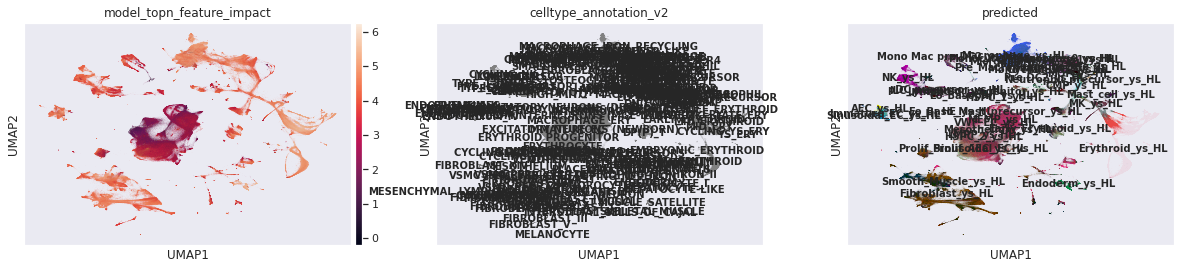

In [34]:
sc.pl.umap(adata_model,color =[ 'model_topn_feature_impact','celltype_annotation_v2','predicted'],legend_loc = 'on data')

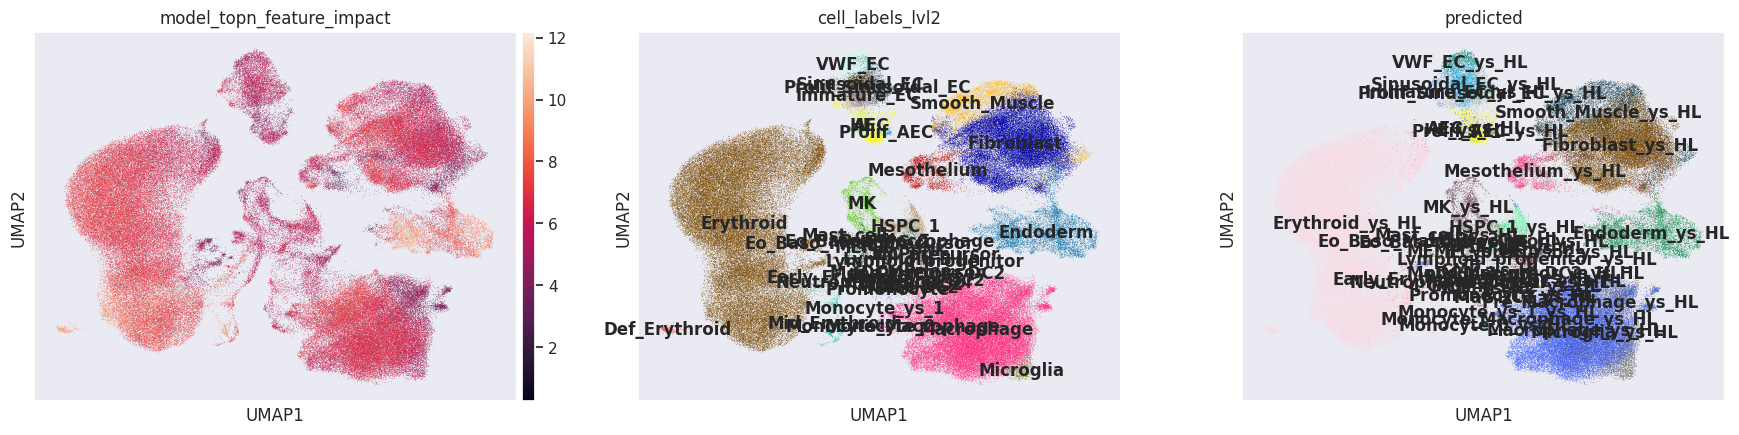

In [18]:
sc.pl.umap(adata_model,color =[ 'model_topn_feature_impact','cell_labels_lvl2','predicted'],legend_loc = 'on data')

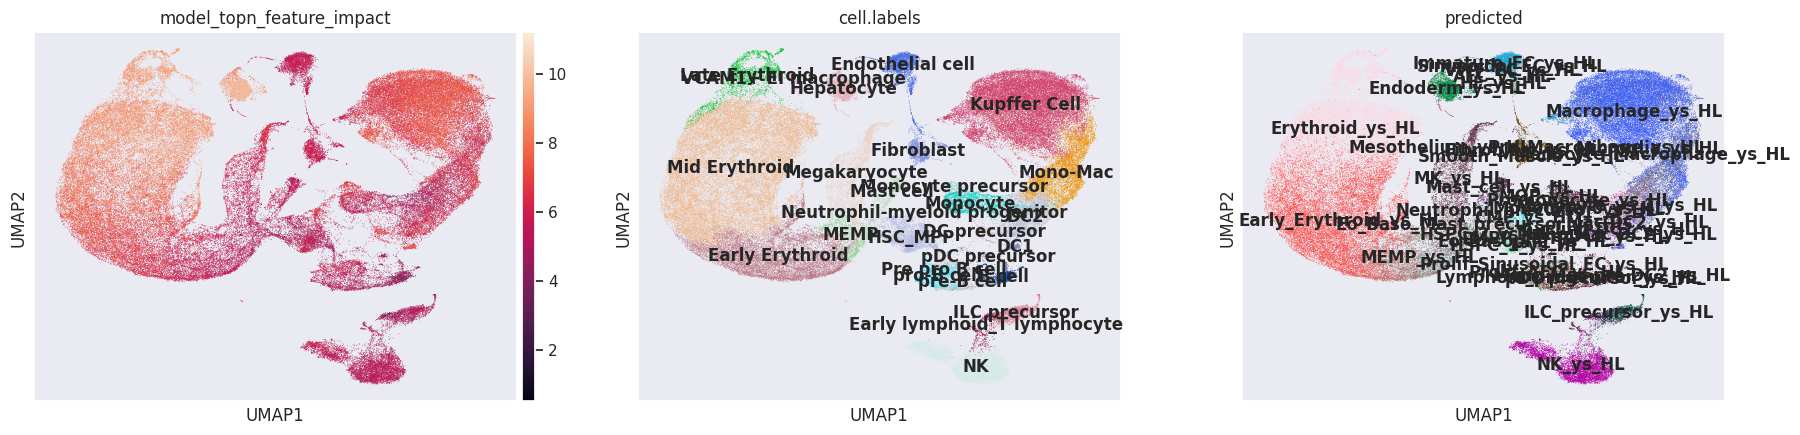

In [7]:
sc.pl.umap(adata_model,color =[ 'model_topn_feature_impact','cell.labels','predicted'],legend_loc = 'on data')

# Calculate differential model feature impact

6


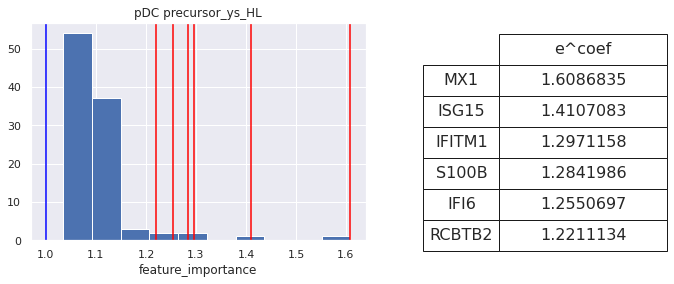

10


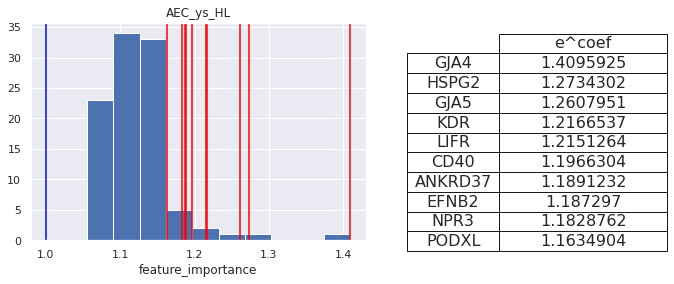

In [136]:
# Estimate dataset specific feature impact
for classes in ['pDC precursor_ys_HL','AEC_ys_HL']:
    model_class_feature_plots(top_loadings, [str(classes)], 'e^coef')
    plt.show()

# Create-desegregated datasets for cross-data per class prediction feature impact
- feature impact is computed above and top features for each model class are recorded below

In [ ]:
adatas = {}

for data in adata.obs[split].unique():
    adatas[split] = adata[adata.obs[split].isin([data])]

In [45]:
split = 'predicted'
data = ['Macrophage_ys_HL']
adatas = {}
adatas[split] = adata_model[adata_model.obs[split].isin(data)]

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


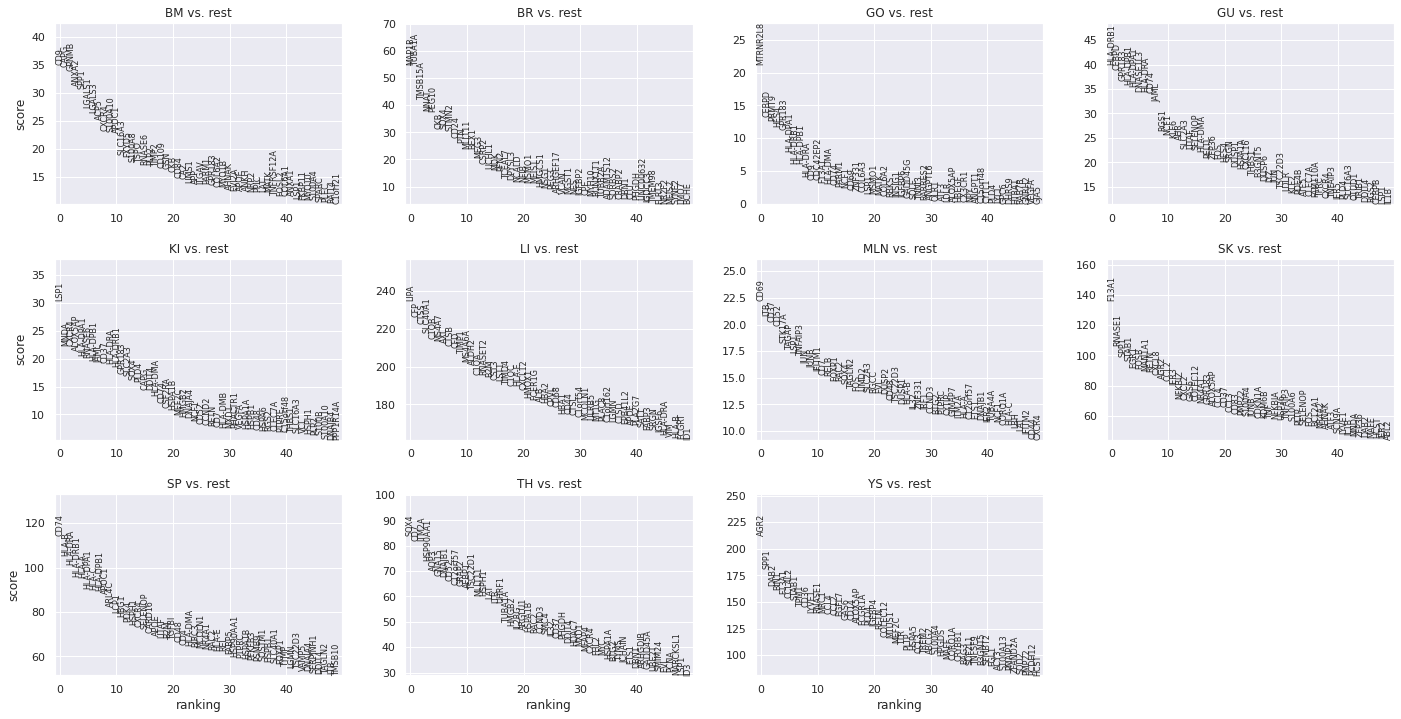

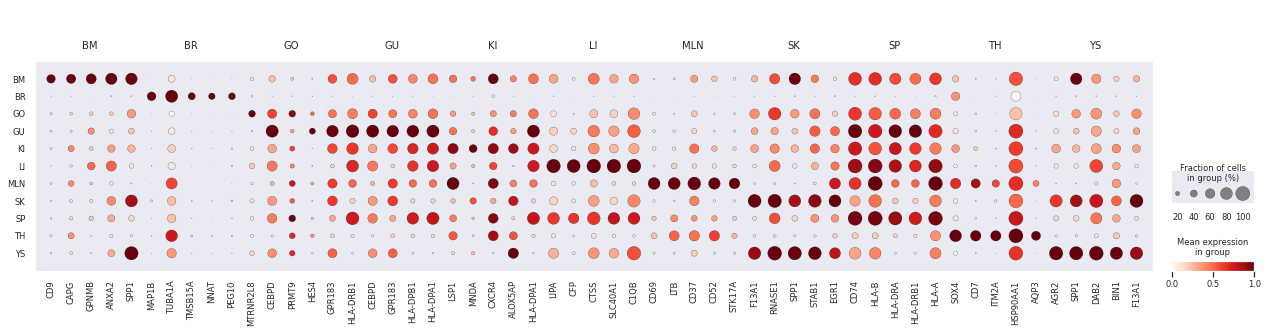

In [46]:
spot_var = 'organ'
sc.tl.rank_genes_groups(adatas[split], spot_var, method='wilcoxon',n_genes=500)
sc.pl.rank_genes_groups(adatas[split], n_genes=50, sharey=False)
result = adatas[split].uns['rank_genes_groups']
groups = result['names'].dtype.names
    
DE = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).head(500)
DE_name =(spot_var + ".csv")
DE.to_csv(DE_name)
degs = DE[:]
if 'concat' in locals() or 'concat' in globals():
    del(concat)
n = degs.loc[:, degs.columns.str.endswith("_n")]
n = pd.melt(n)
p = degs.loc[:, degs.columns.str.endswith("_p")]
p = pd.melt(p)
l = degs.loc[:, degs.columns.str.endswith("_l")]
l = pd.melt(l)
n = n.replace(regex=r'_n', value='')
n = n.rename(columns={"variable": "cluster", "value": "gene"})
p = (p.drop(["variable"],axis = 1)).rename(columns={ "value": "p_val"})
l = (l.drop(["variable"],axis = 1)).rename(columns={ "value": "logfc"})
concat = pd.concat([n,p,l],axis=1)
#remove mito genes from data
concat = concat[~concat["gene"].str.startswith("MT-")]
concat = concat[~concat["gene"].str.startswith("RP11-")]
concat["cluster"] = concat["cluster"].astype(str)
marker_df = concat.groupby('cluster').apply(lambda grp: grp.nsmallest(5, 'p_val')).reset_index(drop=True)
markers = marker_df.groupby('cluster')['gene'].apply(list).to_dict()
markers = dict(sorted(markers.items()))
markers = {str(k):v for k,v in markers.items()}
data_temp = adatas[split]
markers = markers
(sc.pl.dotplot(data_temp, var_names = markers, groupby=spot_var,dendrogram=False,standard_scale='var', color_map='Reds', show = True, save = 'diff_organ_mhcIImac.pdf')) # title=i

# Betweeb class feqatures vs within class features -- descrimniatory

In [ ]:
model_mean_probs = pred_out.loc[:, pred_out.columns != 'consensus_clus_prediction'].groupby('orig_labels').median()
model_mean_probs = model_mean_probs*100
model_mean_probs = model_mean_probs.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
crs_tbl = model_mean_probs.copy()

# Sort df columns by rows
index_order = list(crs_tbl.max(axis=1).sort_values(ascending=False).index)
col_order = list(crs_tbl.max(axis=0).sort_values(ascending=False).index)
crs_tbl = crs_tbl.loc[index_order]
crs_tbl = crs_tbl[col_order]

# Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.color_palette("YlOrBr", as_cmap=True)#sns.color_palette("magma", as_cmap=True)#sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(30,30))
sns.set(font_scale=0.5)
g = sns.heatmap(crs_tbl, cmap=pal,  annot=False,vmin=0, vmax=100, linewidths=1, center=40, square=True, cbar_kws={"shrink": 0.5})

plt.ylabel("Original labels", fontsize=30)
plt.xlabel("Training labels", fontsize=30)
plt.show()
plt.savefig('./ver5_lr_model_means_subclusters.pdf',dpi=300)

# Quick outs QC

In [15]:
# unique pairing counter

#Input columns of interest
var = [freq_redist,"consensus_clus_prediction"]
obs = adata.obs
#get date
from datetime import date
today = date.today()
d1 = (today.strftime("%d/%m/%Y")).replace("/", "_")
# #create df
# annot_sheet = obs[var]
# #annot_sheet = adata.obs[["090920_LJ_lvl1","090920_lvl2_leiden_restricted"]]
# #Drop df suplicates
# annot_sheet = annot_sheet.drop_duplicates()
# annot_sheet = annot_sheet.sort_values(by=var[0])
# annot_sheet = annot_sheet.reset_index(drop=True)
# #Create annotation cat
# for i in var:
#     #Count variates
#     prop = obs.groupby(i).count()
#     dic = dict(zip(prop.index,prop.iloc[:,0]))
#     count_name = "count_" + i 
#     annot_sheet[count_name]=annot_sheet[i].map(dic)
counts = (pd.DataFrame(obs.groupby(var).size()))
counts = counts.loc[~(counts==0).all(axis=1)].reset_index()
var.append('counts')
counts.columns = var
    
#     p = i + "_annot_" + d1
#     print(p)
#     annot_sheet[p] = ""

counts.to_csv("./lvl1_matched_liv_projected_annot.csv")
counts_top = counts.groupby([freq_redist]).apply(lambda x: x.sort_values(["counts"], ascending = False)).reset_index(drop=True).groupby([freq_redist]).head(10)
counts_top.to_csv("./top_lvl1_matched_liv_projected_annot.csv")
counts_top

,cell_labels_lvl2,consensus_clus_prediction,counts
0,AEC,AEC_ys_HL,1707
1,CMP,CMP_ys_HL,25
2,Cycling DC2,Cycling DC2_ys_HL,81
3,Def_Erythroid,Erythroid_ys_HL,289
4,Early_Erythroid,Early_Erythroid_ys_HL,699
5,Endoderm,Endoderm_ys_HL,7656
6,Eo_Baso_Mast_precursor,Eo_Baso_Mast_precursor_ys_HL,56
7,Eo_Basophil,Eo_Basophil_ys_HL,93
8,Erythroid,Erythroid_ys_HL,61038
9,Fibroblast,Fibroblast_ys_HL,28730


# F1 weighted precision score
- This estimates the label robustness in the applied dataset

In [128]:
model = load_models(models,model_key)
model_lr= model

In [129]:
train_x = train_x
train_label = adata.obs['predicted']

In [ ]:
def report_f1(model,train_x, train_label):
    ## Report accuracy score
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn import metrics
    import seaborn as sn
    import pandas as pd
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    
    # cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)
    # # evaluate the model and collect the scores
    # n_scores = cross_val_score(lr, train_x, train_label, scoring='accuracy', cv=cv, n_jobs=-1)
    # # report the model performance
    # print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

    # Report Precision score
    metric = pd.DataFrame((metrics.classification_report(train_label, model.predict(train_x), digits=2,output_dict=True))).T
    cm = confusion_matrix(train_label, model.predict(train_x))
    #cm = confusion_matrix(train_label, model.predict_proba(train_x))
    df_cm = pd.DataFrame(cm, index = lr.classes_,columns = lr.classes_)
    df_cm = (df_cm / df_cm.sum(axis=0))*100
    plt.figure(figsize = (20,15))
    sn.set(font_scale=1) # for label size
    pal = sns.diverging_palette(240, 10, n=10)
    #plt.suptitle(('Mean Accuracy 5 fold: %.3f std: %.3f' % (np.mean(n_scores),  np.std(n_scores))), y=1.05, fontsize=18)
    #Plot precision recall and recall
    table = plt.table(cellText=metric.values,colWidths = [1]*len(metric.columns),
    rowLabels=metric.index,
    colLabels=metric.columns,
    cellLoc = 'center', rowLoc = 'center',
    loc='bottom', bbox=[0.25, -0.6, 0.5, 0.3])
    table.scale(1, 2)
    table.set_fontsize(16)

    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=pal) # font size
    print(metrics.classification_report(train_label, model.predict(train_x), digits=2))

In [ ]:
## Report accuracy score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

lr = model_lr
# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)
# # evaluate the model and collect the scores
# n_scores = cross_val_score(lr, train_x, train_label, scoring='accuracy', cv=cv, n_jobs=-1)
# # report the model performance
# print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# Report Precision score
metric = pd.DataFrame((metrics.classification_report(train_label, model.predict(train_x), digits=2,output_dict=True))).T

cm = confusion_matrix(train_label, model.predict(train_x))
#cm = confusion_matrix(train_label, model.predict_proba(train_x))

df_cm = pd.DataFrame(cm, index = lr.classes_,
                  columns = lr.classes_)
df_cm = (df_cm / df_cm.sum(axis=0))*100
plt.figure(figsize = (20,15))
sn.set(font_scale=1) # for label size
pal = sns.diverging_palette(240, 10, n=10)
#plt.suptitle(('Mean Accuracy 5 fold: %.3f std: %.3f' % (np.mean(n_scores),  np.std(n_scores))), y=1.05, fontsize=18)

#Plot precision recall and recall
table = plt.table(cellText=metric.values,colWidths = [1]*len(metric.columns),
rowLabels=metric.index,
colLabels=metric.columns,
cellLoc = 'center', rowLoc = 'center',
loc='bottom', bbox=[0.25, -0.6, 0.5, 0.3])
table.scale(1, 2)
table.set_fontsize(16)

sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=pal) # font size
print(metrics.classification_report(train_label, model.predict(train_x), digits=2))

# Calculate ROC AUC of projection

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate', fontsize=20)
pyplot.ylabel('True Positive Rate', fontsize=20)
# show the legend
pyplot.legend()
# show the plot
pyplot.show()